# TP3: Image Segmentation With a U-Net - From CPU to GPU

The goal of this notebook is to introduce the notion of **hardware acceleration** in the context of deep learning. We will use the application of image segmentation with a U-Net to illustrate the difference in performance between a CPU and a GPU.

**Image segmentation** is an important task in  computer vision. The goal is to find multiple areas in an image and to assign labels to these area.  It provides a different kind of information than: 
- **image classification** caracterizes images with global labels;
- **object detection** usually relies on finding bounding-boxes around  detected objects

Segmentation is useful and can be used in real-world applications such as medical imaging, clothes segmentation, flooding maps, self-driving cars, etc. There are two types of image segmentation:
- Semantic segmentation: classify each pixel with a label.
- Instance segmentation: classify each pixel and differentiate each object instance.

U-Net is a semantic segmentation technique [originally proposed for medical imaging segmentation](https://arxiv.org/abs/1505.04597). It’s one of the earlier deep learning segmentation models. This architecture is still widely used in more advanced models like Generative Adversarial or Diffusion Network. 

The model architecture is fairly simple: an encoder (for downsampling) and a decoder (for upsampling) with skip connections. U-Net is only based on convolutions. More specifically, the output classification is done at pixel level with a *(1,1)* convolution. It has therefore the following advantages: 
- parameter and data efficiency, 
- independent of the input size. 

The following image is taken from the original paper:

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"  width="60%" height="30%">


In this session, we will consider a binary segmentation task.  

# 1.  Cell nuclei segmentation: the dataset

Cell nuclei segmentation is an essential step in the biological analysis of microscopy images. 
This segmentation can be manually achieved with dedicated software, however it is very costly. 
In this lab session, the starting point is this [nature paper](https://www.nature.com/articles/s41597-020-00608-w). To quote some part of the paper: 

Fully-automated nuclear image segmentation is the prerequisite to ensure statistically significant, quantitative analyses of tissue preparations,applied in digital pathology or quantitative microscopy. The design of segmentation methods that work independently of the tissue type or preparation is complex, due to variations in nuclear morphology, staining intensity, cell density and nuclei aggregations. Machine learning-based segmentation methods can overcome these challenges, however high quality expert-annotated images are required for training. Currently, the limited number of annotated fluorescence image datasets publicly available do not cover a broad range of tissues and preparations. We present a comprehensive, annotated dataset including tightly aggregated nuclei of multiple tissues for the training of machine learning-based nuclear segmentation algorithms. The proposed dataset covers sample preparation methods frequently used in quantitative immunofluorescence microscopy. 

To spare some preprocessing time, this lab session starts with this pickle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pickle
import time
from tqdm.notebook import trange, tqdm

/home/lamsade/averine/miniconda3/envs/edm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lamsade/averine/miniconda3/envs/edm/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
!wget https://www.lamsade.dauphine.fr/~averine/DL3AIISO/nuclei_cells_segmentations.pck .

--2025-10-13 08:34:36--  https://www.lamsade.dauphine.fr/~averine/DL3AIISO/nuclei_cells_segmentations.pck
Résolution de www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)… 193.48.71.250
Connexion à www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443… connecté.
requête HTTP transmise, en attente de la réponse… 404 Not Found
2025-10-13 08:34:36 erreur 404 : Not Found.

Prepended http:// to '.'
--2025-10-13 08:34:36--  http://./
Résolution de . (.)… échec : Nom ou service inconnu.
wget : impossible de résoudre l’adresse de l’hôte « . »


In [3]:
fn = "nuclei_cells_segmentations.pck"
with open(fn, "rb") as f:
    X, Y = pickle.load(f)
print(f"Nuclei images: {X.shape}, Cell images: {Y.shape}")
N = X.shape[0]

Nuclei images: torch.Size([79, 1, 128, 128]), Cell images: torch.Size([79, 1, 128, 128])


Let us visualize some images from the dataset.

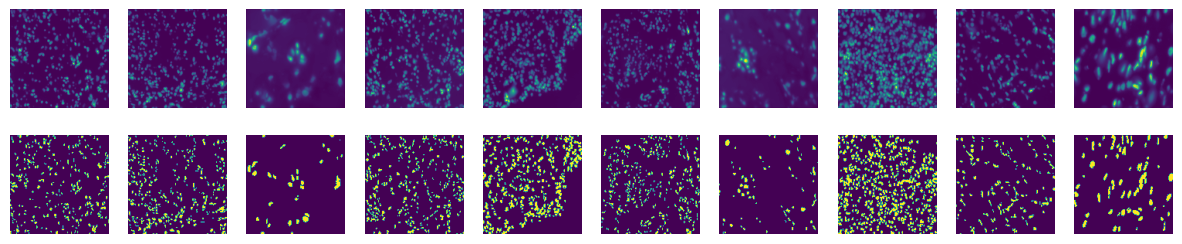

In [4]:
plt.figure(figsize=(15, 3))
for i in range(0, 10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X[i].squeeze())
    plt.axis("off")
    if i == 0:
        plt.ylabel("Nuclei")
    plt.subplot(2, 10, i + 11)
    plt.imshow(Y[i].squeeze())
    plt.axis("off")
    if i == 0:
        plt.ylabel("Cells")
plt.show()

This pickle contains a modified version of the dataset: 
- the same amount of images
- all the images are resized to 128,128
- the segmentation task is converted in a binary pixel classification: nuclei or not. 

The goal is now to train a U-Net on this dataset (69 images for training and 10 for "test"). 

In [5]:
M = 69
trainset = X[:M], Y[:M]
testset = X[M:], Y[M:]

# 2 U-Net Architecture

Following the previous picture of U-Net, the network is composed of 3 parts: encoder, bottleneck, decoder.  
These three steps rely on a convolutional block (convolution, relu, convolution, relu) 

The first step is the **encoder**. The goal is to compress the  "geometrical" information with local features. The encoder first applies a convolution of kernel size (3,3) to extract $F=64$ features. Then the information is compressed using max-pooling (factor 2). The next step does the same:  extract $2\times F=128$ features from the $F=64$, then compression with max-pooling. This operation is repeated 4 times in total to get at the end $F\times 8 = 512$ channels that represent global features extracted from the input image. 

The **bottleneck** layer is a convolutional layer which doubles the number of channels. The idea is to create a "dense" representation of the image to gather both global and local features. 

The **decoder** part is similar to the encoder part but reversed. While we used max-pooling for downsampling in the encoder, the upsampling operation consists in **transposed convolution**. The goal is to increase (so upsample) the spatial dimensions of intermediate feature maps. 

The last peculiarity is the output layer for classification at the pixel level. In U-Net this last layer is (once again) a convolutional layer. This means that with the last hidden layer, we recover the same spatial dimension as the input with $F$ feature maps. The classification is carried out for each pixel independently, but the decision is based on $F$ features that encode global information. 



## 2. U-Net: step by step

Now the goal is to implement U-Net. As a proposed roadmap we propose the following step: 
- a function to create a convolutional block
- a module for the encoder
- a module for the decoder
- and a U-Net module to wrap everything

The number of feature map ($F=64$ in the original work) must be a variable of the UNet. For the first round of experiment, we can use $F=8$.  

In [6]:
def make_conv_block(in_c, out_c, kernel_size=3, stride=1, padding=1):
    """
    Creates a convolutional block with two convolutional layers, each followed by a ReLU activation and batch normalization.

    Args:
        in_c (int): Number of input channels.
        out_c (int): Number of output channels.
        kernel_size (int, optional): Size of the convolving kernel. Default is 3.
        stride (int, optional): Stride of the convolution. Default is 1.
        padding (int, optional): Zero-padding added to both sides of the input. Default is 1.

    Returns:
        nn.Sequential: A sequential container of the convolutional block.
    """
    mod = nn.Sequential(
        nn.Conv2d(
            in_channels=in_c,
            out_channels=out_c,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_c),
        nn.Conv2d(
            in_channels=out_c,
            out_channels=out_c,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(num_features=out_c),
        nn.ReLU(),
    )
    return mod


class encoder_block(nn.Module):
    """Encoder block:
    - a conv block
    - followed by a MaxPooling: the height and width is divided by 2
    We need both the output before and after the max-pooling.
    - the output before the maxpooling is used for the "residual" connection
    - the output after is given to the next encoder block or the bottleneck block.

    Remark: we could use a Sequential module but for the forward we need
    to get x and p
    """

    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = make_conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


class decoder_block(nn.Module):
    """Decoder block:
    - First upsampling is done with a ConvTranspose2D
    - The "residual" connection is implemented with the cat function
    - Then a conv_block is applied.
    The ConvTranspose doubles the height and width.
    The forward call takes two args: the inputs from the previous block and the residual input.
    """

    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = make_conv_block(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """
    UNet model for image segmentation.

    Args:
        factor (int): Base number of filters for the convolutional layers. Default is 64.

    Attributes:
        f (int): Base number of filters for the convolutional layers.
        e1 (nn.Module): First encoder block.
        e2 (nn.Module): Second encoder block.
        e3 (nn.Module): Third encoder block.
        e4 (nn.Module): Fourth encoder block.
        b (nn.Module): Bottleneck convolutional block.
        d1 (nn.Module): First decoder block.
        d2 (nn.Module): Second decoder block.
        d3 (nn.Module): Third decoder block.
        d4 (nn.Module): Fourth decoder block.
        outputs (nn.Conv2d): Final convolutional layer for generating the output.

    Methods:
        forward(inputs):
            Forward pass of the UNet model.

            Args:
                inputs (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

            Returns:
                torch.Tensor: Output tensor of shape (batch_size, 1, height, width).
    """

    def __init__(self, factor=64):
        super().__init__()
        self.f = factor
        """ Encoder """
        self.e1 = encoder_block(1, self.f)
        self.e2 = encoder_block(self.f, self.f * 2)
        self.e3 = encoder_block(self.f * 2, self.f * 4)
        self.e4 = encoder_block(self.f * 4, self.f * 8)

        """ Bottleneck """
        self.b = make_conv_block(self.f * 8, self.f * 16)

        """ Decoder """
        self.d1 = decoder_block(self.f * 16, self.f * 8)
        self.d2 = decoder_block(self.f * 8, self.f * 4)
        self.d3 = decoder_block(self.f * 4, self.f * 2)
        self.d4 = decoder_block(self.f * 2, self.f)

        """ Classifier """
        self.outputs = nn.Conv2d(self.f, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """Encoder"""
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs


class LightUNet(nn.Module):
    """
    LightUNet is a lightweight implementation of the U-Net architecture for image segmentation tasks.
    Attributes:
        f (int): Factor to control the number of filters in the convolutional layers.
        e1 (nn.Module): Encoder block for the first stage.
        b (nn.Module): Bottleneck convolutional block.
        d1 (nn.Module): Decoder block for the first stage.
        outputs (nn.Conv2d): Convolutional layer to produce the final output.
    Methods:
        forward(inputs):
            Forward pass through the network.
            Args:
                inputs (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).
            Returns:
                torch.Tensor: Output tensor with shape (batch_size, 1, height, width).
    """

    def __init__(self, factor=8):
        super().__init__()
        self.f = factor
        """ Encoder """
        self.e1 = encoder_block(1, self.f)

        """ Bottleneck """
        self.b = make_conv_block(self.f, self.f * 2)

        """ Decoder """
        self.d1 = decoder_block(self.f * 2, self.f)

        """ Classifier """
        self.outputs = nn.Conv2d(self.f, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """Encoder"""
        s1, p1 = self.e1(inputs)

        """ Bottleneck """
        b = self.b(p1)

        """ Decoder """
        d1 = self.d1(b, s1)

        """ Classifier """
        outputs = self.outputs(d1)
        return outputs

We can now define two different U-Net with different number of features. Let us compare the speed of inference between the two models.
By default, the model is loaded on CPU. We will then compare the speed of inference on CPU and GPU.


First, let us check if your computer has a GPU.

In [7]:
print(f"GPU available using Cuda: {torch.cuda.is_available()}")
print(
    f"GPU available using MPS: {torch.backends.mps.is_available() and torch.backends.mps.is_built()}"
)
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_available = True
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    gpu_available = True
else:
    device = torch.device("cpu")
    gpu_available = False


print(f"Device: {device}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

GPU available using Cuda: True
GPU available using MPS: False
Device: cuda
Number of GPUs: 2


<font color='blue'>TODO:</font> 
- Run the following cell to compare the speed of inference on CPU and GPU.
- Comment the results.
- Consider running your code on Colab if your own computer does not have a GPU.

In [8]:
model_cpu = UNet(factor=64)
print(
    f"Number of parameters for UNet: {sum(p.numel() for p in model_cpu.parameters())}"
)
light_model_cpu = LightUNet(factor=8)
print(
    f"Number of parameters for LightUNet: {sum(p.numel() for p in light_model_cpu.parameters())}"
)

times_model_cpu = []
times_light_model_cpu = []
model_cpu.eval()
light_model_cpu.eval()
if gpu_available:
    times_model_gpu = []
    times_light_model_gpu = []
    model_gpu = UNet(factor=64).to(device)
    light_model_gpu = LightUNet(factor=8).to(device)
    model_gpu.eval()
    light_model_gpu.eval()

for _ in trange(10):
    t0 = time.time()
    model_cpu(trainset[0])
    t1 = time.time()
    times_model_cpu.append(t1 - t0)
    t0 = time.time()
    light_model_cpu(trainset[0])
    t1 = time.time()
    times_light_model_cpu.append(t1 - t0)
    if gpu_available:
        t0 = time.time()
        model_gpu(trainset[0].to(device))
        t1 = time.time()
        times_model_gpu.append(t1 - t0)
        t0 = time.time()
        light_model_gpu(trainset[0].to(device))
        t1 = time.time()
        times_light_model_gpu.append(t1 - t0)
print(f"UNet CPU: {np.mean(times_model_cpu):.3f} s")
if gpu_available:
    print(f"UNet GPU: {np.mean(times_model_gpu):.3f} s")
    print(f"Inference speedup: {np.mean(times_model_cpu)/np.mean(times_model_gpu):.1f}")
print(f"LightUNet CPU: {np.mean(times_light_model_cpu):.3f} s")
if gpu_available:
    print(f"LightUNet GPU: {np.mean(times_light_model_gpu):.3f} s")
    print(
        f"Inference speedup: {np.mean(times_light_model_cpu)/np.mean(times_light_model_gpu):.1f}"
    )
    del model_gpu, light_model_gpu
del model_cpu, light_model_cpu

Number of parameters for UNet: 31042369
Number of parameters for LightUNet: 6553


  0%|          | 0/10 [00:00<?, ?it/s]

UNet CPU: 2.244 s
UNet GPU: 0.193 s
Inference speedup: 11.6
LightUNet CPU: 0.247 s
LightUNet GPU: 0.077 s
Inference speedup: 3.2


We can also compare the speed of inference of GPU with different batch sizes.

  0%|          | 0/7 [00:00<?, ?it/s]

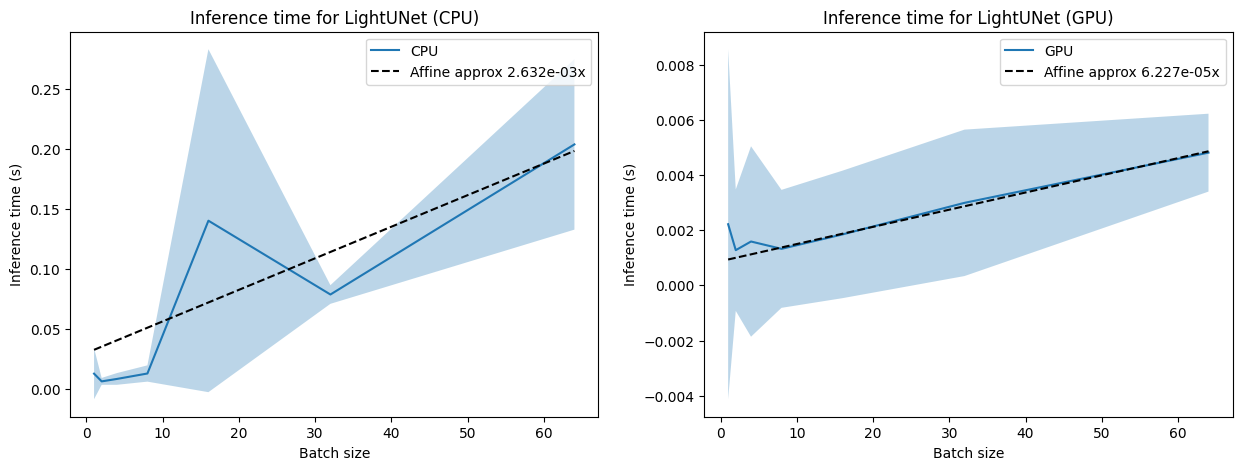

In [9]:
if gpu_available:
    time_inference_cpu_mean = []
    time_inference_gpu_mean = []
    time_inference_cpu_std = []
    time_inference_gpu_std = []
    light_model_cpu = LightUNet(factor=8)
    light_model_cpu.eval()
    light_model_gpu = LightUNet(factor=8).to(device)
    light_model_gpu.eval()
    with torch.no_grad():
        for i in trange(0, 7):
            time_inference_cpu = []
            time_inference_gpu = []
            batch_size = 2**i
            for i in range(20):
                t0 = time.time()
                light_model_cpu(trainset[0][:batch_size])
                t1 = time.time()
                time_inference_cpu.append(t1 - t0)
            time_inference_cpu_mean.append(np.mean(time_inference_cpu))
            time_inference_cpu_std.append(np.std(time_inference_cpu))
            for i in range(20):
                t0 = time.time()
                light_model_gpu(trainset[0][:batch_size].to(device))
                t1 = time.time()
                time_inference_gpu.append(t1 - t0)
            time_inference_gpu_mean.append(np.mean(time_inference_gpu))
            time_inference_gpu_std.append(np.std(time_inference_gpu))
    del light_model_cpu, light_model_gpu

    x = [2**i for i in range(7)]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, time_inference_cpu_mean, label="CPU")
    plt.fill_between(
        x,
        np.array(time_inference_cpu_mean) - np.array(time_inference_cpu_std),
        np.array(time_inference_cpu_mean) + np.array(time_inference_cpu_std),
        alpha=0.3,
    )
    affine_approx = np.polyfit(x[3:], time_inference_cpu_mean[3:], 1)
    plt.plot(
        x,
        np.polyval(affine_approx, x),
        linestyle="--",
        color="black",
        label=f"Affine approx {affine_approx[0]:.3e}x",
    )

    plt.xlabel("Batch size")
    plt.title("Inference time for LightUNet (CPU)")
    plt.ylabel("Inference time (s)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, time_inference_gpu_mean, label="GPU")
    plt.fill_between(
        x,
        np.array(time_inference_gpu_mean) - np.array(time_inference_gpu_std),
        np.array(time_inference_gpu_mean) + np.array(time_inference_gpu_std),
        alpha=0.3,
    )
    affine_approx = np.polyfit(x[3:], time_inference_gpu_mean[3:], 1)
    plt.plot(
        x,
        np.polyval(affine_approx, x),
        linestyle="--",
        color="black",
        label=f"Affine approx {affine_approx[0]:.3e}x",
    )
    plt.xlabel("Batch size")
    plt.ylabel("Inference time (s)")
    plt.title("Inference time for LightUNet (GPU)")
    plt.legend()
    plt.show()

We can do the same thing with the training time:

  0%|          | 0/7 [00:00<?, ?it/s]

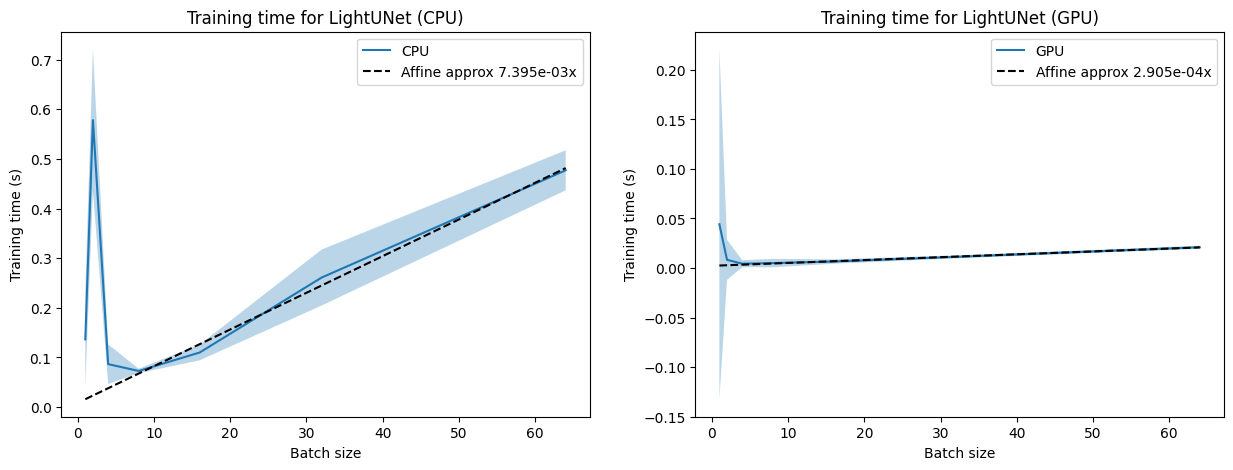

In [10]:
if gpu_available:
    time_training_cpu_mean = []
    time_training_gpu_mean = []
    time_training_cpu_std = []
    time_training_gpu_std = []
    light_model_cpu = LightUNet(factor=8)
    light_model_cpu.train()
    light_model_gpu = LightUNet(factor=8).to(device)
    light_model_gpu.train()
    criterion = nn.MSELoss()
    optimizer_cpu = torch.optim.Adam(light_model_cpu.parameters(), lr=0.001)
    optimizer_gpu = torch.optim.Adam(light_model_gpu.parameters(), lr=0.001)
    for i in trange(0, 7):
        time_inference_cpu = []
        time_inference_gpu = []
        batch_size = 2**i
        for i in range(2):
            t0 = time.time()
            optimizer_cpu.zero_grad()
            outputs = light_model_cpu(trainset[0][:batch_size])
            loss = criterion(outputs, trainset[1][:batch_size])
            loss.backward()
            optimizer_cpu.step()
            t1 = time.time()
            time_inference_cpu.append(t1 - t0)
        time_training_cpu_mean.append(np.mean(time_inference_cpu))
        time_training_cpu_std.append(np.std(time_inference_cpu))
        for i in range(20):
            t0 = time.time()
            optimizer_gpu.zero_grad()
            outputs = light_model_gpu(trainset[0][:batch_size].to(device))
            loss = criterion(outputs, trainset[1][:batch_size].to(device))
            loss.backward()
            optimizer_gpu.step()
            t1 = time.time()
            time_inference_gpu.append(t1 - t0)
        time_training_gpu_mean.append(np.mean(time_inference_gpu))
        time_training_gpu_std.append(np.std(time_inference_gpu))
    del light_model_cpu, light_model_gpu

    x = [2**i for i in range(7)]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, time_training_cpu_mean, label="CPU")
    plt.fill_between(
        x,
        np.array(time_training_cpu_mean) - np.array(time_training_cpu_std),
        np.array(time_training_cpu_mean) + np.array(time_training_cpu_std),
        alpha=0.3,
    )
    affine_approx = np.polyfit(x[3:], time_training_cpu_mean[3:], 1)
    plt.plot(
        x,
        np.polyval(affine_approx, x),
        linestyle="--",
        color="black",
        label=f"Affine approx {affine_approx[0]:.3e}x",
    )
    plt.xlabel("Batch size")
    plt.title("Training time for LightUNet (CPU)")
    plt.ylabel("Training time (s)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, time_training_gpu_mean, label="GPU")
    plt.fill_between(
        x,
        np.array(time_training_gpu_mean) - np.array(time_training_gpu_std),
        np.array(time_training_gpu_mean) + np.array(time_training_gpu_std),
        alpha=0.3,
    )
    affine_approx = np.polyfit(x[3:], time_training_gpu_mean[3:], 1)
    plt.plot(
        x,
        np.polyval(affine_approx, x),
        linestyle="--",
        color="black",
        label=f"Affine approx {affine_approx[0]:.3e}x",
    )
    plt.xlabel("Batch size")
    plt.ylabel("Training time (s)")
    plt.title("Training time for LightUNet (GPU)")
    plt.legend()
    plt.show()

<font color='blue'>TODO:</font>
- Compare the training/inference time on CPU and GPU.
- Comment the results.

From now on, the code will be GPU or CPU agnostic. The code will automatically detect if a GPU is available and use it. If not, the code will run on CPU. To do so, we will use the `torch.device` object. 

```python
device = torch.device("cuda" if gpu_available else "cpu")
model = model.to(device)
input = input.to(device)
```

And every time, we need to manipulate results, we will use the following code: 

```python
output = model(input)
output = output.cpu().detach().numpy()
```
The `detach()` method is used to detach the output from the computational graph (no Grad attached). The `cpu()` method is used to move the output from the GPU to the CPU. The `numpy()` method is used to convert the output to a numpy array.


# 3. Training the U-Net

We will now build functions to train the U-Net. The next cell contains the following functions:
- a function to train the model and evaluate the model





In [11]:
def train(
    model, trainset, devset=None, nepochs=10, lr0=1e-2, threshold=0, device="cpu"
):
    """Train a model
    Args:
    - model: the model to train
    - trainset: a tuple (X,Y) of the training data
    - devset: a tuple (X,Y) of the development data
    - nepochs: number of epochs
    - lr0: initial learning rate
    - threshold: threshold for the accuracy
    - device: the device to use
    Output:
    - the trained model
    """
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr0)
    losses = torch.zeros(nepochs)
    dlosses = torch.zeros(nepochs)
    accs = torch.zeros(nepochs)
    train, labels = trainset
    dev, dlabels = devset
    for e in range(nepochs):
        ### train part
        optim.zero_grad()
        preds = model(train)
        l = lossfn(preds, labels)
        l.backward()
        optim.step()
        losses[e] = l.item()
        accs[e] = (
            ((preds > threshold) * 1 == labels).sum()
            * 100
            / (preds.shape[0] * preds.shape[1] * preds.shape[2] * preds.shape[3])
        )
        ### dev eval
        model.eval()
        preds = model(dev)
        l = lossfn(preds, dlabels)
        dlosses[e] = l.item()
        model.train()
        if e % 10 == 0:
            print(
                f"Epoch {e} | Loss {losses[e]:.3f} | Acc {accs[e]:.2f} | Dev Loss {dlosses[e]:.3f}"
            )
    print(
        f"Epoch {e} | Loss {losses[e]:.3f} | Acc {accs[e]:.2f} | Dev Loss {dlosses[e]:.3f}"
    )
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Train")
    plt.plot(dlosses, label="Dev")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return model

<font color='blue'>TODO:</font>
- Run the following cell to train the U-Net for 5 epochs (on CPU).


Epoch 0 | Loss 0.599 | Acc 79.10 | Dev Loss 0.577
Epoch 4 | Loss 0.381 | Acc 94.20 | Dev Loss 0.466


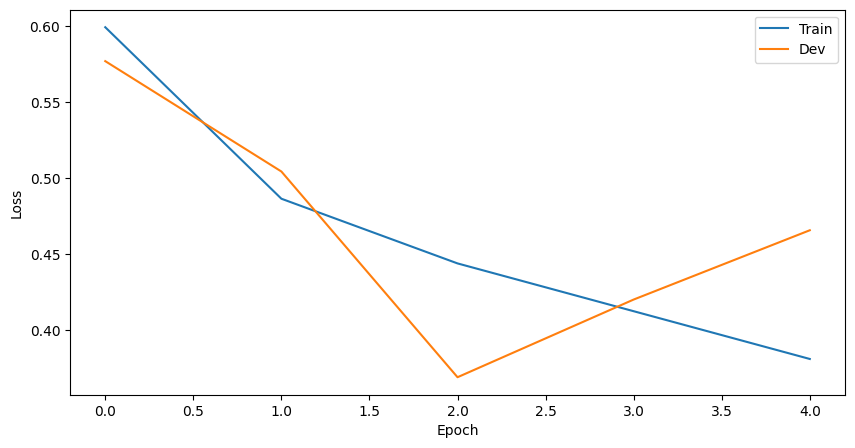

In [12]:
m8 = LightUNet(8)
m8 = train(m8, trainset, testset, 5, lr0=2e-2, threshold=0)

<font color='blue'>TODO:</font>
- Modify the code to use the GPU.
- Train the U-Net for 100 epochs.
- Compare the training time between CPU and GPU.

In [ ]:
def train(
    model, trainset, devset=None, nepochs=10, lr0=1e-2, threshold=0, device="cpu"
):
    """Train a model
    Args:
    - model: the model to train
    - trainset: a tuple (X,Y) of the training data
    - devset: a tuple (X,Y) of the development data
    - nepochs: number of epochs
    - lr0: initial learning rate
    - threshold: threshold for the accuracy
    - device: the device to use
    """
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr0)
    losses = torch.zeros(nepochs)
    dlosses = torch.zeros(nepochs)
    accs = torch.zeros(nepochs)
    train, labels = trainset
    dev, dlabels = devset
    train, labels = train.to(device), labels.to(device)
    dev, dlabels = dev.to(device), dlabels.to(device)
    for e in range(nepochs):
        ### train part
        optim.zero_grad()
        preds = model(train)
        l = lossfn(preds, labels)
        l.backward()
        optim.step()
        losses[e] = l.cpu().item()
        accs[e] = (
            ((preds > threshold) * 1 == labels).sum()
            * 100
            / (preds.shape[0] * preds.shape[1] * preds.shape[2] * preds.shape[3])
        )
        ### dev eval
        model.eval()
        preds = model(dev)
        l = lossfn(preds, dlabels)
        dlosses[e] = l.cpu().item()
        model.train()
        if e % 10 == 0:
            print(
                f"Epoch {e} | Loss {losses[e]:.3f} | Acc {accs[e]:.2f} | Dev Loss {dlosses[e]:.3f}"
            )
    print(
        f"Epoch {e} | Loss {losses[e]:.3f} | Acc {accs[e]:.2f} | Dev Loss {dlosses[e]:.3f}"
    )
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Train")
    plt.plot(dlosses, label="Dev")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch 0 | Loss 0.699 | Acc 68.82 | Dev Loss 0.652
Epoch 10 | Loss 0.306 | Acc 93.77 | Dev Loss 0.343
Epoch 20 | Loss 0.153 | Acc 95.68 | Dev Loss 0.334
Epoch 30 | Loss 0.105 | Acc 96.30 | Dev Loss 0.216
Epoch 40 | Loss 0.092 | Acc 96.60 | Dev Loss 0.189
Epoch 50 | Loss 0.087 | Acc 96.73 | Dev Loss 0.155
Epoch 60 | Loss 0.079 | Acc 97.02 | Dev Loss 0.144
Epoch 70 | Loss 0.074 | Acc 97.18 | Dev Loss 0.242
Epoch 80 | Loss 0.071 | Acc 97.30 | Dev Loss 0.204
Epoch 90 | Loss 0.068 | Acc 97.41 | Dev Loss 0.225
Epoch 99 | Loss 0.073 | Acc 97.23 | Dev Loss 0.202


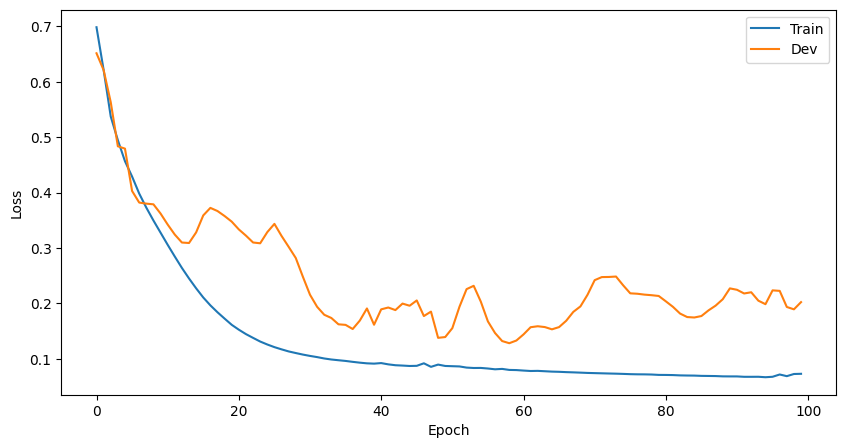

In [14]:
m8 = LightUNet(8).to(device)
m8 = train(m8, trainset, testset, 100, lr0=2e-2, threshold=0, device=device)

<font color='blue'>TODO:</font>
- Modify the code to return the model with the best validation loss.

To do so, we will use the following code to save the model at a given epoch. 

```python
state_dict = model.state_dict()
torch.save(state_dict, 'model.pth')
```

And the following code to load the model at the end of the training. 

```python
model.load_state_dict(torch.load('model.pth'))
```

In [33]:
print(m8.state_dict().values())

odict_values([tensor([[[[-5.9783e-02,  8.4276e-02,  2.8991e-01],
          [-1.0279e-01,  1.3271e-01,  2.5332e-01],
          [-2.3340e-01,  3.3514e-01,  3.4148e-01]]],


        [[[ 3.1223e-01, -7.6972e-02, -8.8728e-02],
          [-1.7021e-01,  4.0670e-01, -3.8167e-03],
          [-1.1402e-01, -1.3528e-02, -1.9892e-01]]],


        [[[ 1.1426e-01, -6.5098e-04, -3.1508e-01],
          [-1.4259e-01, -1.0496e-01,  7.3071e-02],
          [-1.4684e-01,  3.9651e-01,  7.0114e-02]]],


        [[[ 1.5125e-01,  1.3121e-01, -9.3945e-02],
          [ 2.5831e-01,  5.7180e-01,  5.9289e-01],
          [-1.9224e-01, -2.8784e-01,  2.3280e-01]]],


        [[[-1.5439e-01,  2.3186e-02, -1.3099e-01],
          [-2.0159e-01,  9.2242e-01, -1.4192e-01],
          [ 2.9166e-02,  1.7318e-01, -3.6681e-01]]],


        [[[-7.6241e-02, -1.9469e-01, -1.1284e-01],
          [-2.3750e-01,  1.8858e-01,  3.8964e-01],
          [-2.9431e-01, -4.7223e-03,  2.4648e-01]]],


        [[[-1.4733e-01, -5.8762e-02, -4.1243

In [ ]:
def train(
    model, trainset, devset=None, nepochs=10, lr0=1e-2, threshold=0, device="cpu"
):
    """Train a model
    Args:
    - model: the model to train
    - trainset: a tuple (X,Y) of the training data
    - devset: a tuple (X,Y) of the development data
    - nepochs: number of epochs
    - lr0: initial learning rate
    - threshold: threshold for the accuracy
    - device: the device to use
    """
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr0)
    losses = torch.zeros(nepochs)
    dlosses = torch.zeros(nepochs)
    accs = torch.zeros(nepochs)
    train, labels = trainset
    # Shuffle the training data
    idx = torch.randperm(train.shape[0])
    train, labels = train[idx], labels[idx]

    dev, dlabels = devset
    min_dloss = 1e10
    train, labels = train.to(device), labels.to(device)
    dev, dlabels = dev.to(device), dlabels.to(device)
    for e in range(nepochs):
        ### train part
        optim.zero_grad()
        preds = model(train)
        l = lossfn(preds, labels)
        l.backward()
        optim.step()
        losses[e] = l.cpu().item()
        accs[e] = (
            ((preds > threshold) * 1 == labels).sum()
            * 100
            / (preds.shape[0] * preds.shape[1] * preds.shape[2] * preds.shape[3])
        )
        ### dev eval
        model.eval()
        preds = model(dev)
        l = lossfn(preds, dlabels)
        dlosses[e] = l.cpu().item()
        model.train()
        if dlosses[e] < min_dloss:
            best_model = model.state_dict()
            torch.save(best_model, "best_model.pth")
            del best_model
            best_epoch = e
            min_dloss = dlosses[e]

        if e % 10 == 0:
            print(
                f"Epoch {e} | Loss {losses[e]:.3f} | Acc {accs[e]:.2f} | Dev Loss {dlosses[e]:.3f} | Best Dev Loss {min_dloss:.3f} at epoch {best_epoch}"
            )
    print(
        f"Epoch {e} | Loss {losses[e]:.3f} | Acc {accs[e]:.2f} | Dev Loss {dlosses[e]:.3f} | Best Dev Loss {min_dloss:.3f} at epoch {best_epoch}"
    )
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Train")
    plt.plot(dlosses, label="Dev")
    plt.plot(best_epoch, dlosses[best_epoch], "ro", label="Best model")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    model.load_state_dict(torch.load("best_model.pth"))
    return model

Epoch 0 | Loss 0.655 | Acc 68.97 | Dev Loss 0.660 | Best Dev Loss 0.660 at epoch 0
Epoch 10 | Loss 0.329 | Acc 91.50 | Dev Loss 0.246 | Best Dev Loss 0.229 at epoch 8
Epoch 20 | Loss 0.173 | Acc 95.19 | Dev Loss 0.208 | Best Dev Loss 0.206 at epoch 13
Epoch 30 | Loss 0.112 | Acc 96.05 | Dev Loss 0.167 | Best Dev Loss 0.163 at epoch 28
Epoch 40 | Loss 0.095 | Acc 96.45 | Dev Loss 0.139 | Best Dev Loss 0.139 at epoch 40
Epoch 50 | Loss 0.087 | Acc 96.63 | Dev Loss 0.133 | Best Dev Loss 0.132 at epoch 49
Epoch 60 | Loss 0.081 | Acc 96.89 | Dev Loss 0.148 | Best Dev Loss 0.132 at epoch 49
Epoch 70 | Loss 0.076 | Acc 97.02 | Dev Loss 0.138 | Best Dev Loss 0.125 at epoch 68
Epoch 80 | Loss 0.073 | Acc 97.14 | Dev Loss 0.164 | Best Dev Loss 0.125 at epoch 68
Epoch 90 | Loss 0.070 | Acc 97.28 | Dev Loss 0.153 | Best Dev Loss 0.125 at epoch 68
Epoch 99 | Loss 0.067 | Acc 97.37 | Dev Loss 0.152 | Best Dev Loss 0.125 at epoch 68


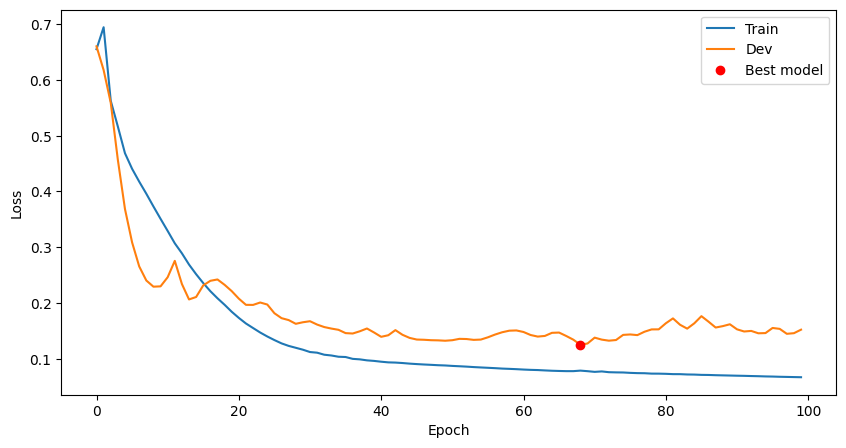

In [16]:
m8 = LightUNet(8).to(device)
m8 = train(m8, trainset, testset, 100, lr0=2e-2, threshold=0, device=device)

The following cell contains the code to assess the performance of the model on the test set. Include the following functions:
- a function to plot the results
- a function to plot the PR curve

The PR curve is a good way to assess the performance of a binary classifier. It is a plot of the precision against the recall for the different thresholds. 

The precision is the number of true positive divided by the number of true positive and false positive. Intuitively, it is the ability of the classifier not to label as positive a sample that is negative.

The recall is the number of true positive divided by the number of true positive and false negative. Intuitively, it is the ability of the classifier to find all the positive samples.

In [45]:
def plotres(m, testset, device, threshold=0):
    """
    Plots the results of a model's predictions on a test set.

    Args:
        m (torch.nn.Module): The model to evaluate.
        testset (tuple): A tuple containing the test inputs and ground truth labels (x, y).
        device (torch.device): The device to run the model on (e.g., torch.device("cuda") or torch.device("cpu")).

    Returns:
        None
    """

    m.eval()
    x, y = testset
    x, y = x.to(device), y.to(device)
    testid = range(x.shape[0])
    plt.figure(figsize=(5, 10))
    for i in testid:
        out = m(x[i].unsqueeze(0)).squeeze().detach()
        plt.subplot(10, 4, i * 4 + 1)
        if i == 0:
            plt.title("Input")
        plt.imshow(x[i].cpu().squeeze())
        plt.axis("off")
        plt.subplot(10, 4, i * 4 + 2)
        if i == 0:
            plt.title("Output")
        out = m(x[i].unsqueeze(0)).squeeze().detach()
        plt.imshow(out.cpu())
        plt.axis("off")
        plt.subplot(10, 4, i * 4 + 3)
        if i == 0:
            plt.title(f"Output>{threshold}")
        plt.imshow((out > threshold).cpu())
        plt.axis("off")
        plt.subplot(10, 4, i * 4 + 4)
        if i == 0:
            plt.title("Ground Truth")
        plt.imshow(y[i].cpu().squeeze() == 1)
        plt.axis("off")
    plt.show()
    m.train()


def plotthreshold(m, testset, start=-2, end=2, nsteps=10, device="cpu"):
    """
    Plots the results visually of a model's predictions on a test set for different thresholds. for the 1st image of the test set

    Args:
        m (torch.nn.Module): The model to evaluate.
        testset (tuple): A tuple containing the test inputs and ground truth labels (x, y).
        start (float): The starting threshold value.
        end (float): The ending threshold value.
        nsteps (int): The number of steps between start and end for threshold values.
        device (torch.device): The device to run the model on (e.g., torch.device("cuda") or torch.device("cpu")).

    Returns:
        None
    """

    m.eval()
    x, y = testset
    x, y = x[0:1].to(device), y[0:1].to(device)
    plt.figure(figsize=(5, 25))
    out = m(x).squeeze().detach()
    plt.subplot(nsteps + 3, 1, 1)
    plt.title("Input")
    plt.imshow(x[0].cpu().squeeze())
    plt.axis("off")
    plt.subplot(nsteps + 3, 1, 2)
    plt.title("m")
    plt.imshow(out.cpu())
    plt.axis("off")
    plt.subplot(nsteps + 3, 1, 3)
    plt.title("Ground Truth")
    plt.imshow(y[0].cpu().squeeze() == 1)
    plt.axis("off")
    for i, thr in enumerate(np.linspace(start, end, nsteps)):
        plt.subplot(nsteps + 3, 1, i + 4)
        plt.title(f"m(x)>{thr:.2f}")
        plt.imshow((out > thr).cpu())
        plt.axis("off")
    plt.tight_layout()
    plt.show()


def evalseg(preds, labels, thr=0):
    """Evaluate a segmentation model
    Args:
    - preds: the predictions
    - labels: the ground truth
    - thr: the threshold
    Output:
    - accuracy, precision, recall
    """
    Tot = preds.numel()
    if preds.ndim == 3:
        preds = preds.unsqueeze(0)
    out = preds.squeeze().detach()
    selx = out > thr
    sely = (labels == 1).squeeze()
    x1 = (selx * 1).sum()
    y1 = (sely * 1).sum()
    inters = selx == sely
    acc = inters.sum() * 100 / Tot
    prec = selx[inters].sum() * 100 / x1
    rapp = sely[inters].sum() * 100 / y1
    return acc.cpu().item(), prec.cpu().item(), rapp.cpu().item()


def plotroc(m, testset, start=-2, end=2, nsteps=50, device="cpu"):
    """
    Plots the ROC curve for a given model or list of models on a test dataset.

    Parameters:
        m (torch.nn.Module or list of torch.nn.Module): The model or list of models to evaluate.
        testset (tuple): A tuple containing the test data (x, y).
        start (float, optional): The starting threshold value for ROC calculation. Default is -2.
        end (float, optional): The ending threshold value for ROC calculation. Default is 2.
        nsteps (int, optional): The number of steps between start and end for threshold values. Default is 50.
        device (str, optional): The device to run the model on ("cpu" or "cuda"). Default is "cpu".

    Returns:
    None: This function does not return anything. It plots the ROC curve.
    """
    plt.figure(figsize=(5, 5))
    lm = None
    if isinstance(m, list):
        lm = m
    else:
        lm = [m]
    idx = 0
    x, y = testset
    if device == torch.device("cuda"):
        x, y = x.to(device), y.to(device)
    for m in lm:
        preds = m(x)
        roc = []
        for thr in np.linspace(start, end, nsteps):
            acc, prec, rap = evalseg(preds, y, thr)
            roc.append([prec, rap])
            # print(thr, prec, rap)
        roc = np.array(roc)
        plt.scatter(roc[:, 0], roc[:, 1], label=str(idx), alpha=0.5)
        idx += 1
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend()
    plt.xlim(0, 100)
    plt.ylim(0, 100)

<font color='blue'>TODO:</font>
- Run the following cell to assess the performance of the model on the test set.

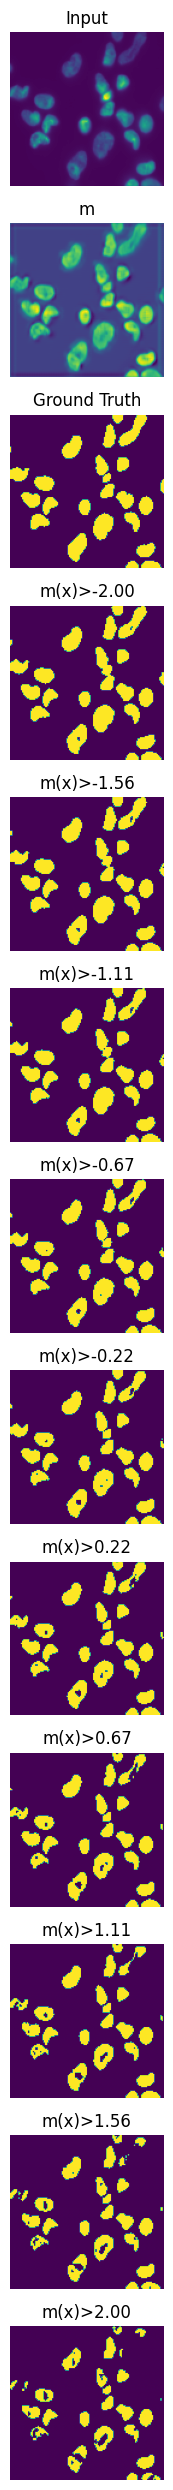

In [46]:
plotthreshold(m8, testset, start=-2, end=2, nsteps=10, device=device)

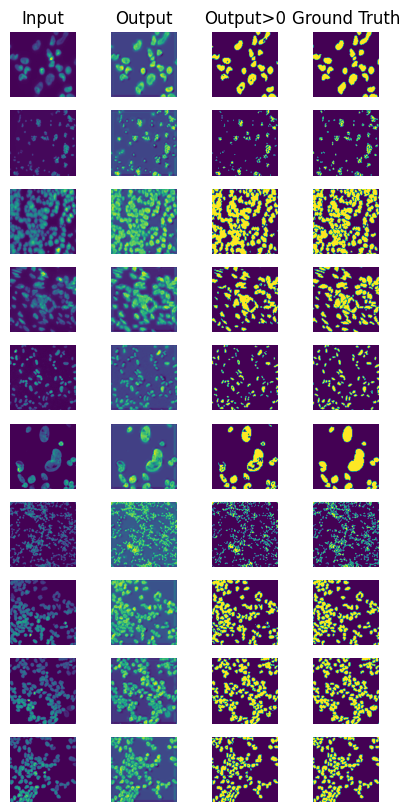

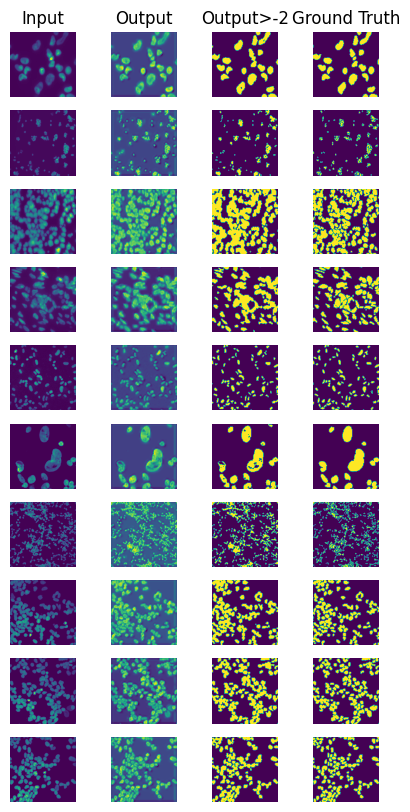

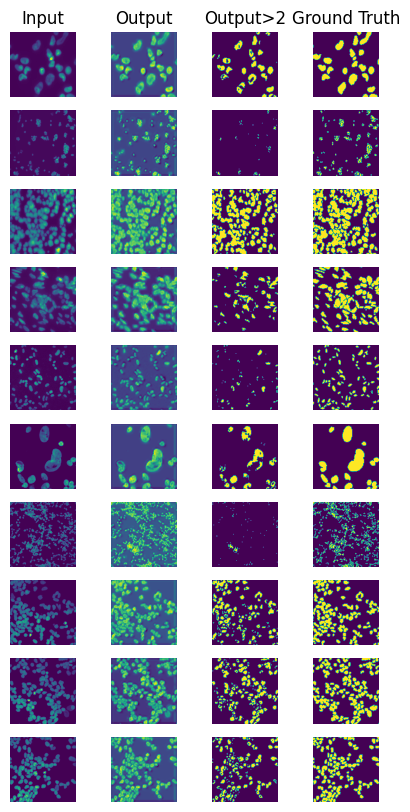

In [36]:
plotres(m8, testset, device)
plotres(m8, testset, device, -2)
plotres(m8, testset, device, 2)

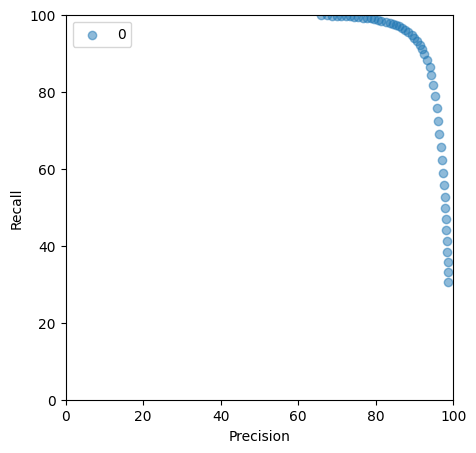

In [19]:
plotroc(m8, testset, -5, 5, 50, device)

<font color='blue'>TODO:</font>
- Train different U-Net with different number of features (4 and 16).
- Make sure to have the best learning rate for each model by observing the training loss.
- Compare the performance of the different models on the test set.

Epoch 0 | Loss 0.619 | Acc 74.14 | Dev Loss 0.615 | Best Dev Loss 0.615 at epoch 0
Epoch 10 | Loss 0.375 | Acc 74.14 | Dev Loss 0.393 | Best Dev Loss 0.393 at epoch 10
Epoch 20 | Loss 0.305 | Acc 74.14 | Dev Loss 0.581 | Best Dev Loss 0.314 at epoch 14
Epoch 30 | Loss 0.262 | Acc 74.14 | Dev Loss 0.365 | Best Dev Loss 0.314 at epoch 14
Epoch 40 | Loss 0.227 | Acc 95.41 | Dev Loss 0.316 | Best Dev Loss 0.314 at epoch 14
Epoch 50 | Loss 0.199 | Acc 95.96 | Dev Loss 0.225 | Best Dev Loss 0.225 at epoch 50
Epoch 60 | Loss 0.176 | Acc 96.33 | Dev Loss 0.218 | Best Dev Loss 0.199 at epoch 57
Epoch 70 | Loss 0.156 | Acc 96.61 | Dev Loss 0.174 | Best Dev Loss 0.174 at epoch 70
Epoch 80 | Loss 0.142 | Acc 96.78 | Dev Loss 0.169 | Best Dev Loss 0.164 at epoch 76
Epoch 90 | Loss 0.136 | Acc 96.78 | Dev Loss 0.182 | Best Dev Loss 0.159 at epoch 87
Epoch 99 | Loss 0.126 | Acc 96.85 | Dev Loss 0.152 | Best Dev Loss 0.152 at epoch 99


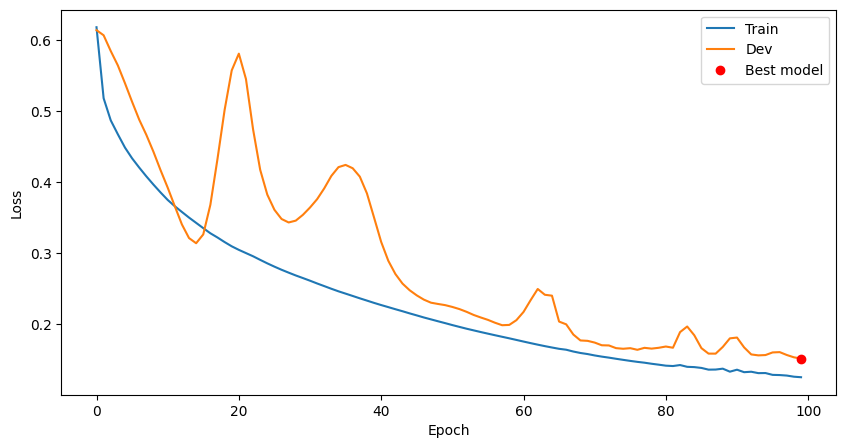

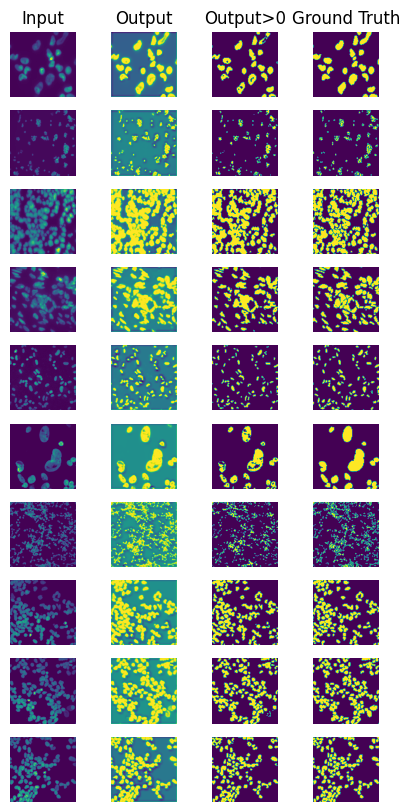

In [20]:
m4 = LightUNet(4).to(device)
m4 = train(m4, trainset, testset, 100, lr0=2e-2, device=device)
plotres(m4, testset, device)

Epoch 0 | Loss 0.710 | Acc 31.28 | Dev Loss 0.684 | Best Dev Loss 0.684 at epoch 0
Epoch 10 | Loss 0.353 | Acc 94.29 | Dev Loss 0.413 | Best Dev Loss 0.413 at epoch 10
Epoch 20 | Loss 0.245 | Acc 95.99 | Dev Loss 0.295 | Best Dev Loss 0.295 at epoch 20
Epoch 30 | Loss 0.173 | Acc 96.61 | Dev Loss 0.253 | Best Dev Loss 0.253 at epoch 30
Epoch 40 | Loss 0.129 | Acc 96.97 | Dev Loss 0.204 | Best Dev Loss 0.204 at epoch 40
Epoch 50 | Loss 0.104 | Acc 97.19 | Dev Loss 0.209 | Best Dev Loss 0.196 at epoch 45
Epoch 60 | Loss 0.089 | Acc 97.41 | Dev Loss 0.206 | Best Dev Loss 0.196 at epoch 45
Epoch 70 | Loss 0.082 | Acc 97.41 | Dev Loss 0.158 | Best Dev Loss 0.157 at epoch 69
Epoch 80 | Loss 0.074 | Acc 97.60 | Dev Loss 0.161 | Best Dev Loss 0.152 at epoch 76
Epoch 90 | Loss 0.068 | Acc 97.70 | Dev Loss 0.167 | Best Dev Loss 0.152 at epoch 76
Epoch 99 | Loss 0.064 | Acc 97.79 | Dev Loss 0.175 | Best Dev Loss 0.152 at epoch 76


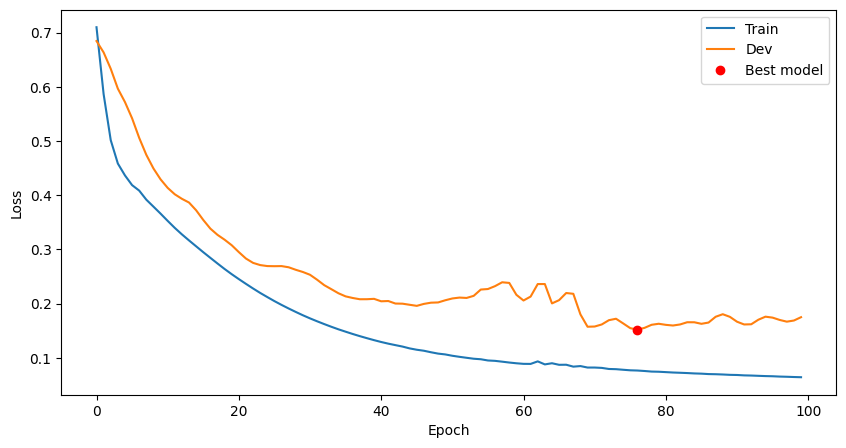

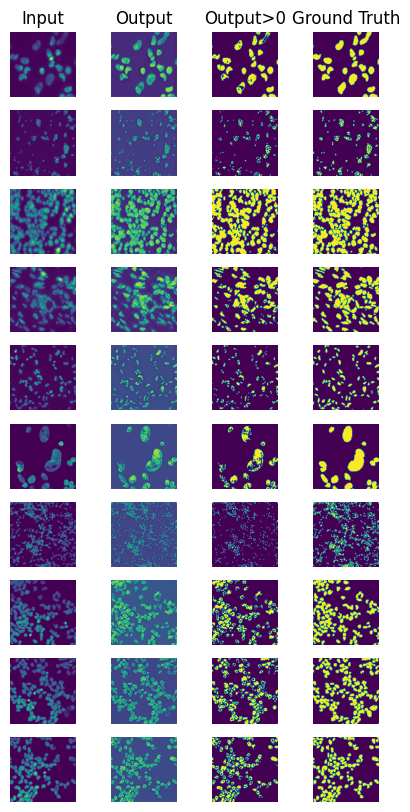

In [21]:
m16 = LightUNet(16).to(device)
m16 = train(m16, trainset, testset, 100, lr0=5e-3, device=device)
plotres(m16, testset, device)

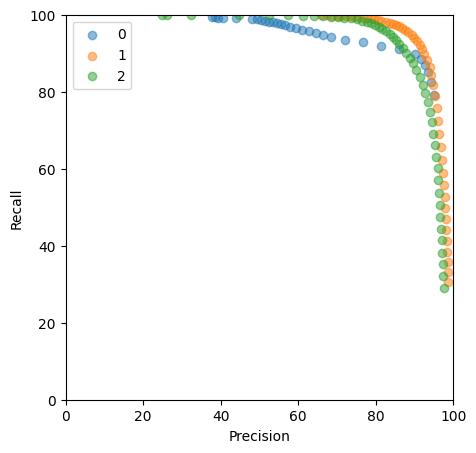

In [22]:
plotroc([m4, m8, m16], testset, -5, 5, 50, device)

<font color='blue'>TODO:</font>
- Train a larger U-Net with 8 and 16 features for 200 epochs.

Epoch 0 | Loss 0.675 | Acc 67.68 | Dev Loss 0.627 | Best Dev Loss 0.627 at epoch 0
Epoch 10 | Loss 0.407 | Acc 95.27 | Dev Loss 0.518 | Best Dev Loss 0.498 at epoch 8
Epoch 20 | Loss 0.339 | Acc 96.31 | Dev Loss 0.416 | Best Dev Loss 0.416 at epoch 20
Epoch 30 | Loss 0.283 | Acc 96.72 | Dev Loss 0.373 | Best Dev Loss 0.373 at epoch 30
Epoch 40 | Loss 0.233 | Acc 97.01 | Dev Loss 0.288 | Best Dev Loss 0.288 at epoch 40
Epoch 50 | Loss 0.190 | Acc 97.38 | Dev Loss 0.282 | Best Dev Loss 0.282 at epoch 50
Epoch 60 | Loss 0.155 | Acc 97.68 | Dev Loss 0.248 | Best Dev Loss 0.248 at epoch 60
Epoch 70 | Loss 0.129 | Acc 97.90 | Dev Loss 0.202 | Best Dev Loss 0.202 at epoch 70
Epoch 80 | Loss 0.107 | Acc 98.07 | Dev Loss 0.216 | Best Dev Loss 0.201 at epoch 73
Epoch 90 | Loss 0.092 | Acc 98.20 | Dev Loss 0.204 | Best Dev Loss 0.191 at epoch 89
Epoch 100 | Loss 0.080 | Acc 98.33 | Dev Loss 0.221 | Best Dev Loss 0.191 at epoch 89
Epoch 110 | Loss 0.072 | Acc 98.35 | Dev Loss 0.168 | Best Dev Loss

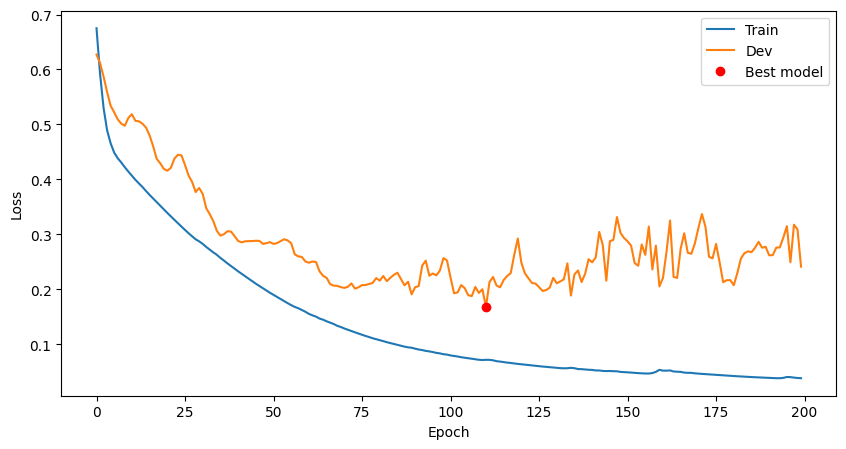

In [23]:
bm8 = UNet(8).to(device)
bm8 = train(bm8, trainset, testset, 200, lr0=5e-3, device=device)

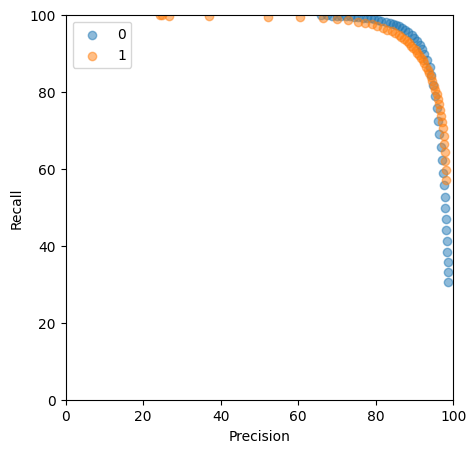

In [24]:
plotroc([m8, bm8], testset, -5, 5, 50, device)

Epoch 0 | Loss 0.626 | Acc 73.87 | Dev Loss 0.616 | Best Dev Loss 0.616 at epoch 0
Epoch 10 | Loss 0.293 | Acc 95.06 | Dev Loss 0.627 | Best Dev Loss 0.586 at epoch 2
Epoch 20 | Loss 0.207 | Acc 96.11 | Dev Loss 0.453 | Best Dev Loss 0.453 at epoch 20
Epoch 30 | Loss 0.147 | Acc 96.67 | Dev Loss 0.306 | Best Dev Loss 0.306 at epoch 30
Epoch 40 | Loss 0.109 | Acc 97.18 | Dev Loss 0.228 | Best Dev Loss 0.228 at epoch 40
Epoch 50 | Loss 0.086 | Acc 97.54 | Dev Loss 0.167 | Best Dev Loss 0.167 at epoch 50
Epoch 60 | Loss 0.072 | Acc 97.77 | Dev Loss 0.167 | Best Dev Loss 0.164 at epoch 56
Epoch 70 | Loss 0.061 | Acc 98.05 | Dev Loss 0.164 | Best Dev Loss 0.143 at epoch 62
Epoch 80 | Loss 0.060 | Acc 98.00 | Dev Loss 0.259 | Best Dev Loss 0.143 at epoch 62
Epoch 90 | Loss 0.054 | Acc 98.13 | Dev Loss 0.208 | Best Dev Loss 0.128 at epoch 84
Epoch 100 | Loss 0.049 | Acc 98.29 | Dev Loss 0.188 | Best Dev Loss 0.128 at epoch 84
Epoch 110 | Loss 0.046 | Acc 98.37 | Dev Loss 0.217 | Best Dev Loss

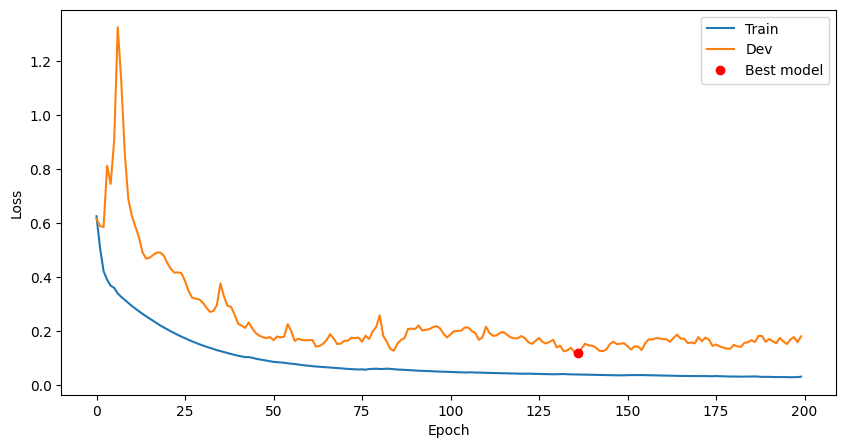

In [25]:
bm16 = UNet(16).to(device)
bm16 = train(bm16, trainset, testset, 200, lr0=5e-3, device=device)

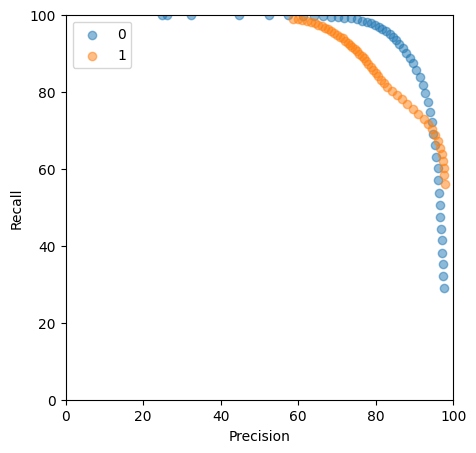

In [26]:
plotroc([m16, bm16], testset, -5, 5, 50, device)

Epoch 0 | Loss 0.644 | Acc 76.54 | Dev Loss 0.601 | Best Dev Loss 0.601 at epoch 0
Epoch 10 | Loss 0.219 | Acc 95.85 | Dev Loss 15.972 | Best Dev Loss 0.601 at epoch 0
Epoch 20 | Loss 0.135 | Acc 96.76 | Dev Loss 0.373 | Best Dev Loss 0.369 at epoch 19
Epoch 30 | Loss 0.098 | Acc 97.13 | Dev Loss 0.365 | Best Dev Loss 0.272 at epoch 27
Epoch 40 | Loss 0.076 | Acc 97.54 | Dev Loss 0.542 | Best Dev Loss 0.272 at epoch 27
Epoch 50 | Loss 0.063 | Acc 97.83 | Dev Loss 0.268 | Best Dev Loss 0.253 at epoch 49
Epoch 60 | Loss 0.054 | Acc 98.08 | Dev Loss 0.251 | Best Dev Loss 0.202 at epoch 53
Epoch 70 | Loss 0.049 | Acc 98.23 | Dev Loss 0.333 | Best Dev Loss 0.202 at epoch 53
Epoch 80 | Loss 0.057 | Acc 97.89 | Dev Loss 0.164 | Best Dev Loss 0.164 at epoch 80
Epoch 90 | Loss 0.050 | Acc 98.10 | Dev Loss 0.150 | Best Dev Loss 0.117 at epoch 85
Epoch 100 | Loss 0.045 | Acc 98.29 | Dev Loss 0.196 | Best Dev Loss 0.117 at epoch 85
Epoch 110 | Loss 0.041 | Acc 98.43 | Dev Loss 0.228 | Best Dev Los

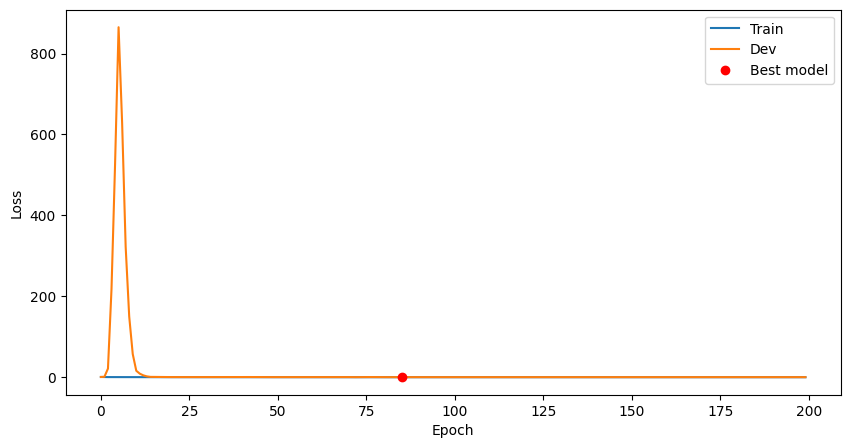

In [27]:
bm32 = UNet(32).to(device)
bm32 = train(bm32, trainset, testset, 200, lr0=5e-3, device=device)

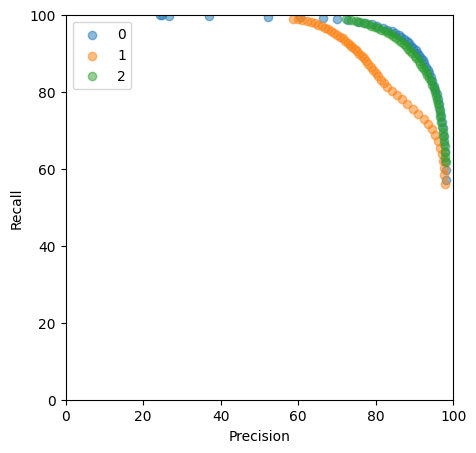

In [28]:
plotroc([bm8, bm16, bm32], testset, -5, 5, 50, device)

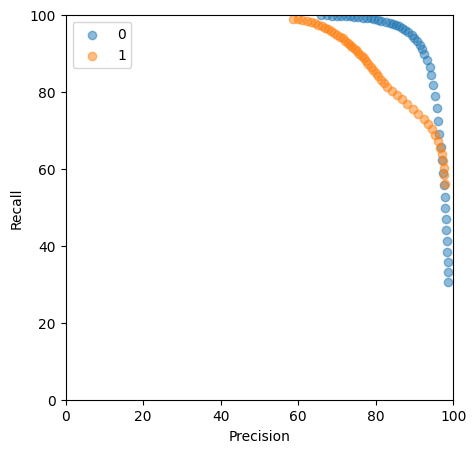

In [29]:
plotroc(
    [m8, bm16],
    testset,
    -5,
    5,
    50,
    device,
)